
# Assignment 2

   ### Write your registration number here:

    Upload your updated notebook with the title: Assignment-2-YourRegistrationNumber.ipynb

**Deliverable is the completed notebook (no .pdf or images are needed) with your comments and the implemented functions.**
The sections in this notebook are as follow:

0. Environment and imports
1. Discretisation of Action/State Space
2. Implemementation of SARSA. I will provide this implementation so you can understand how the discretisations are used.
3. *Task-1:* Q-learning: In here you will need to create the entire Q-learning implementation following a similar structure than for the case of SARSA
4. *Task-2:* $n$-step SARSA: In here you you will need to create the entire $n$-stepo SARSA implementation following a similar structure than for the case of SARSA
5. *Task-3:* REINFORCE: Assuming that you have a feature vector $x(a,s)$ implement the REINFORCE algorithm using the soft-max policy over the discretised actions . 
6. **PGT Only** *Task-4*: SARSA($\lambda$): Implement the backward view of SARSA($\lambda$). You will need to think about an appropriate feature vector.

## 0. Environment and Imports

The environment we will be dealing with is **the inverted pendulum.** 

![](https://miro.medium.com/max/1000/1*TNo3x9zDi1lVOH_3ncG7Aw.gif)

To implement this environment, we will make use of the gym library.

In [315]:
import gym
import numpy as np
import random
from tqdm.notebook import tqdm # to keep track of the progress
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

To check that the environment is working,  execute the following cell. A window with an animation of the pendulum should open, display some random actions, and close automatically.

In [316]:
env = gym.make('Pendulum-v1').env

state = env.reset()
for _ in range(300):
    env.render()
    state, reward, done, _ = env.step(env.action_space.sample()) # take a random action
env.close()

The goal of this environment is to bring the pendulum into the upper neutral position, where the angle $\theta = 0$ and the angular velocitiy $\frac{\text{d}}{\text{d}t}\theta=\omega=0$. The reward function is already designed that way and does not need further specification. For further information about the environment you may refer to the code and documentation of OpenAI's `gym`:

[Documentation of the gym pendulum](https://github.com/openai/gym/wiki/Pendulum-v1)

[Pendulum environment in the gym Github repository](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)

## 1. Discretisation of Action and State Space

The inverted pendulum comes with a continuous action and state space. Although it is possible to handle systems with these characteristics (for example with `Policy Gradient Methods`). This assignment will only focus on the discrete case. Therefore  we will represent the inverted pendulum within a discrete state / action space. For this, a discretisation is necessary.

The pendulum has `three state` variables relating to the momentary angular position $\theta$:
\begin{align*}
x=\begin{bmatrix}
\text{cos}(\theta)\\
\text{sin}(\theta)\\
\frac{\text{d}}{\text{d}t}\theta
\end{bmatrix}
\in
\begin{bmatrix}
[-1.0, 1.0]\\
[-1.0, 1.0]\\
[-8.0, 8.0]
\end{bmatrix},
\end{align*}

and `one action` variable, which relates to the torque applied at the axis of rotation:

$u = T \in [-2.0 , 2.0 ]$

After the discretisation, we want the system to be defined on sets of non-negative natural numbers:

\begin{align*}
x_d=
\text{discretise_state}(x)
\in
\begin{bmatrix}
\{0,1,2,...,d_{\theta}-1\}\\
\{0,1,2,...,d_{\theta}-1\}\\
\{0,1,2,...,d_{\omega}-1\}
\end{bmatrix},
\end{align*}


$
u_d=
\text{discretise_action}(u)
\in
\{0,1,2,...,d_{T}-1\}.
$

The `step()` function of the environment receives a `continuous` action, therefore we need to transform our discrete action space, into a continuous one:

$
u=
\text{continualsze_action}(u_d):
\{0,1,2,...,d_{T}-1\} \rightarrow [-2, 2]
.
$

   The procedure will be as follows: `env.state()` generates a `continuous` state, we need to turn that state into a discrete one `disc_state`, using our policy we will obtain an associated discrete action `disc_action`, we will transform it into a continuous action `action`, use the function `env.step(action)` and we will obtain the respective new (continuous) state, reward and whether we have finished or not. If we haven't finished, we repeate the process.

A parametrization of $d_\theta = d_\omega = d_T = 15$ can be used to yield satisfactory results in this exercise (at least for $n$-step SARSA).
Any other `odd` number should work too, but it is unclear which one is the best. `Even` have an issue that we will discuss a bit later.

### 1.1 Discretisation - Continualisation

The number of discretisation intervals can in fact make a difference in this case. The inverted pendulum can be considered as solved when brought into the upper neutral position $\theta=0, \omega=0$. The state as given by `gym` would therefore be:

\begin{align*}
x_\text{neutral}=
\begin{bmatrix}
\text{cos}(0)\\
\text{sin}(0)\\
0
\end{bmatrix}
=
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix},\quad
u_\text{neutral}=0
\end{align*}

Consequently, the discretisation / continualisation should allow for precise transformation of this state, which is given when assuming an `odd` number of discretization intervals. If one uses an `even` number of intervals, one interval boundary will be located exactly at zero, potentially leading to rapid bouncing around the neutral position.

In [317]:
d_T = 15  # number of discrete actions
d_theta = 15 # 2$pi$/15
d_omega = 15 

def discretise_state(states):   
    
    limits = [1, 1, 8]
    num_disc_intervals = [d_theta, d_theta, d_omega]
    
    q_intervals = [np.linspace(-l, l, i+1) for l, i in zip(limits, num_disc_intervals)]
    return np.array([np.digitize(s, q).clip(max=q.size - 1) - 1 for s, q in zip(states, q_intervals)], 
                    dtype=int)  # int is necessary for indexing
    
    
def continualise_action(disc_action):    
    
    limit = 2
    interval_length = 2 / (d_T-1)
    norm_action = disc_action * interval_length
    cont_action = (norm_action - 1) * limit
    return np.array(cont_action).flatten()


Let's see those two functions in action:

In [318]:
env = gym.make('Pendulum-v1').env
state = env.reset()
for _ in range(2):
    disc_action = np.random.choice(range(d_T))
    cont_action = continualise_action(disc_action)
    print("discrete action: {}, continuous action: {}".format(disc_action, cont_action))
    
    state, reward, done, _ = env.step(cont_action) # take a random action
    disc_state = discretise_state(state)
    print("discrete state: {}, continuous state: {}".format(disc_state, state))
    
env.close()

discrete action: 13, continuous action: [1.71428571]
discrete state: [ 7 14  8], continuous state: [-0.01065125  0.99994326  0.83843154]
discrete action: 9, continuous action: [0.57142857]
discrete state: [ 6 14  9], continuous state: [-0.09421667  0.9955517   1.6741033 ]


### 1.2 Discretisation Diagrams

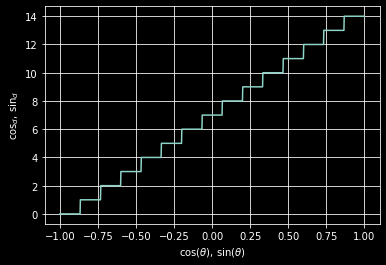

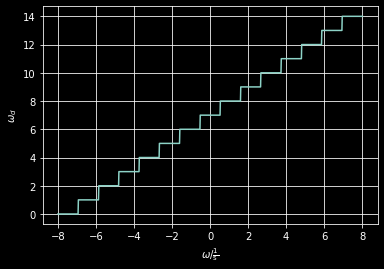

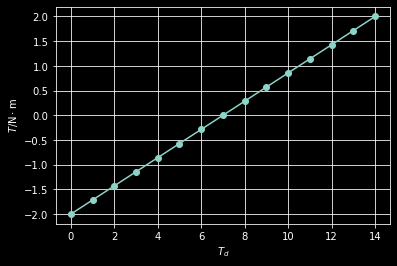

In [319]:
cos_theta = np.linspace(-1, 1, 1000)
sin_theta = np.linspace(-1, 1, 1000)
omega = np.linspace(-8, 8, 1000)
T = np.arange(0, d_T, 1)

disc_states = np.array([discretise_state(np.array([c, s, o])) for c, s, o in zip(cos_theta, sin_theta, omega)])
cont_actions = [continualise_action(np.array(t)) for t in T]

plt.plot(cos_theta, disc_states[:, 0])
plt.xlabel(r"cos$(\theta)$, sin$(\theta)$")
plt.ylabel(r"cos${}_d$, sin${}_d$")
plt.grid()
plt.show()
plt.plot(omega, disc_states[:, 2])
plt.xlabel(r"$\omega / \frac{1}{\mathrm{s}}$")
plt.ylabel(r"$\omega_d$")
plt.grid()
plt.show()
plt.plot(T, cont_actions, 'o-')
plt.xlabel(r"$T_d$")
plt.ylabel(r"$T / \mathrm{N} \cdot \mathrm{m}$")
plt.grid()
plt.show()

In [320]:
def tester(policy):
    env = gym.make('Pendulum-v1').env
    import time

    nb_steps = 400

    state = env.reset() # initialize s_0 (a continuous state)
    disc_state = tuple(discretise_state(state)) # discretise the state and assign it as a tuple (useful for $n$-step SARSA)
    disc_action = policy[disc_state] #select the respective discrete action

    for k in range(nb_steps):
        
        cont_action = continualise_action(disc_action)    # transform the discrete action into a continuous one
        env.render() 
        time.sleep(0.005)
        next_state, reward, done, _ = env.step(cont_action)   # use the continuous actions for the transitions
        disc_next_state = tuple(discretise_state(next_state))  # discretise the next state
        
        if done:
            break
        
        disc_action = policy[disc_next_state] # get the next discrete action, and repeat.
    
    env.close()

In [321]:
def plot_rewards(cum_rew, method=None):
    plt.plot(cum_rew)
    plt.xlabel("episode")
    plt.ylabel(r"$\sum R$")
    plt.title(method)
    plt.show()

## 2. SARSA

In the following I provide a SARSA implementation for the environment, to teach you how to use the discretisations/continualisation.

In [322]:
def sarsa(env, num_episodes, alpha, epsilon, gamma=1.0, decay=0.99995):

    Q = np.zeros([d_theta, d_theta, d_omega, d_T])
    policy = np.zeros((d_theta, d_theta, d_omega), dtype=int)
    cumulative_reward_history = [] # we can use this to figure out how well the learning worked

    for i_episode in tqdm(range(num_episodes)):
        # monitor progress
        
        state = env.reset()# start episode
        disc_state = tuple(discretise_state(state))
        disc_action = np.random.choice(np.arange(d_T))

    
        epsilon *= decay
        alpha *= decay
        rewards = []
        
        for _ in range(num_steps):
            cont_action = continualise_action(disc_action)
            next_state, reward, done, info = env.step(cont_action) # take action A, observe R, S'
            next_disc_state = tuple(discretise_state(next_state))
            rewards.append(reward)
            if not done:
                if np.random.uniform(0,1)<epsilon:
                    next_disc_action = np.random.choice(range(d_T))
                else:
                    next_disc_action = policy[next_disc_state] # epsilon-greedy action
                Q[disc_state][disc_action]  += alpha*(reward+ gamma*Q[next_disc_state][next_disc_action] - Q[disc_state][disc_action])
                policy[disc_state] = np.argmax(Q[disc_state])
                disc_state = next_disc_state     # S <- S'
                disc_action = next_disc_action   # A <- A'
            if done:
                Q[disc_state][disc_action] += alpha*(reward-Q[disc_state][disc_action])  #reached terminal state
                policy[disc_state] = np.argmax(Q[disc_state])
                break
        cumulative_reward_history.append(np.sum(rewards))
     
    return Q, policy,cumulative_reward_history

### Setting the parameters for the experiments.
Use the following parameters: $\alpha=0.1, \gamma=0.9, \epsilon=0.1$.

To really **test** the performance of the methods you should set them as follow:

- For `SARSA`: `num_episodes = 5000` and `num_steps = 500`
- For `Q-Learning`: `num_episodes = 10000` and `num_steps = 500`
- For `$n$-step SARSA`: `num_episodes = 3000` and `num_steps = 500`. Try $n=10$ for example.
- For `REINFORCE` and `SARSA($\lambda$)`: `num_episodes = 5000` and `num_steps = 100` should work (if you find a suitable feature vector).

For **checking** that your algorithms are doing what they intend to do, use `num_episodes = 200` and `num_steps = 50`, otherwise it will take you too long.



In [323]:
env = gym.make('Pendulum-v1').env


alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.1 # epsilon greedy parameter

num_episodes = 200 # number of episodes
num_steps = 50 # length of episodes

In [324]:
Q_sarsa,policy_sarsa, cum_rew_sarsa = sarsa(env, num_episodes, alpha, epsilon, gamma, decay=1)#0.99995)
env.close()



  0%|          | 0/200 [00:00<?, ?it/s]

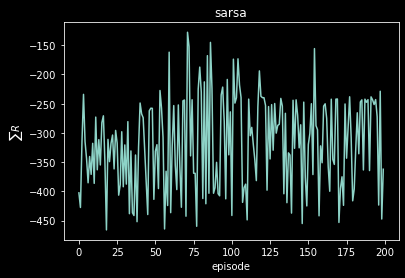

In [325]:
plot_rewards(cum_rew_sarsa, method='sarsa')

In [326]:
tester(policy_sarsa)

## 3. *Task-1:* Q-Learning

- **UG**: 40 marks
- **PG**: 35 marks

Create function `q_learning` that receives as input 
1. `env`, 
2. `num_episodes`, 
3. `alpha`, 
4. `epsilon`, 
5. `gamma`, 
6. `decay`

And it returns the `Q` values, the respective final `policy` and cumulative `rewards`.
Follow the structure of `SARSA` as defined above, and what we did in the Lab-6. Check also the pseudo-code in the textbook [http://www.incompleteideas.net/book/RLbook2020.pdf ](Reinforcement Learning: an Introduction) Page 131.

In [327]:
def q_learning(env, num_episodes, alpha, epsilon, gamma=1.0, decay=0.99995):
    
    #intialization
    
    Q = np.zeros([d_theta, d_theta, d_omega, d_T])
    policy = np.zeros((d_theta, d_theta, d_omega), dtype=int)
    cumulative_reward_history = [] # we can use this to figure out how well the learning worked
    
    for i_episode in tqdm(range(num_episodes)):
        
        #discretization
        state = env.reset()
        disc_state = tuple(discretise_state(state))
        disc_action = np.random.choice(np.arange(d_T))

        #applying decay coefficient on epsilon and alpha
        epsilon *= decay
        alpha *= decay
        rewards = []
        
        for _ in range(num_steps):
            #continualization of the action
            cont_action = continualise_action(disc_action)
            next_state, reward, done, info = env.step(cont_action)
            next_disc_state = tuple(discretise_state(next_state))
            rewards.append(reward)
            # checking whether we reach the final state or not
            # if we have not reached the final state, then we need to pick an action based on the policy
            if not done:
                if np.random.uniform(0,1)<epsilon:
                    next_disc_action = np.random.choice(range(d_T))
                else:
                    next_disc_action = policy[next_disc_state]
                # updating the q_learning Q vector and policy
                Q[disc_state][disc_action]  += alpha*(reward+ gamma*Q[next_disc_state][next_disc_action] - Q[disc_state][disc_action])
                policy[disc_state] = np.argmax(Q[disc_state])
                disc_state = next_disc_state     # S := S+1
            if done:
                Q[disc_state][disc_action] += alpha*(reward-Q[disc_state][disc_action])  
                #this is the terminal state so break and compute the cumlative reward
                break
        cumulative_reward_history.append(np.sum(rewards))
    
    
    return Q, policy, cumulative_reward_history


Write here the parameters you will use. For checking that your algorithm works well, you can use `num_episodes = 200` and `num_steps = 50`. But for checking their performance, `Q-Learning` requires more training: `num_episodes = 10000` and `num_steps = 500`.

In [328]:
env = gym.make('Pendulum-v1').env


alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.2 # epsilon greedy parameter

num_episodes = 200 # number of episodes
num_steps = 50 # length of episodes

Call the function `q_learning` assigning it to some arrays. Then plot its cumulative rewards (with function `plot_rewards`) and run the environment (with function `tester`)

In [329]:
Q_q_learn,policy_q_learn, cum_rew_q_learn = q_learning(env, num_episodes, alpha, epsilon, gamma, decay=0.95)#0.99995)
env.close()


  0%|          | 0/200 [00:00<?, ?it/s]

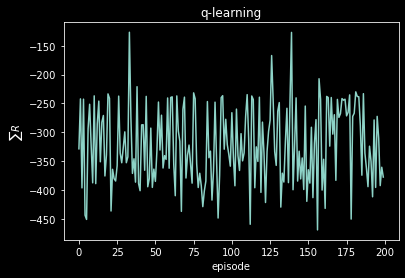

In [330]:
plot_rewards(cum_rew_q_learn, method='q-learning')

In [331]:
tester(policy_q_learn)

## 4. *Task-2:* $n$-step SARSA
- **UG:** 50 marks
- **PG:** 40 marks

Create function `n_step_sarsa` that receives as input 
1. `env`, 
2. `num_episodes`, 
3. `n`, 
4. `alpha`, 
5. `epsilon`, 
6. `gamma`, 
7. `decay`

And it returns the `Q` values, the respective final `policy` and cumulative `rewards`.

Remember that for $n$-step methods, you need to accumulate the values of states visited, action taken and rewards received for $n$ steps. Take a look to Lab-6 for an idea on how to implement this. Check also the pseudo-code in the textbook [http://www.incompleteideas.net/book/RLbook2020.pdf ](Reinforcement Learning: an Introduction) Page 147.

In [332]:
def n_step_sarsa(env, num_episodes, n,  alpha, epsilon, gamma=1.0, decay=0.99995):
    
    #initialization
    Q = np.zeros([d_theta, d_theta, d_omega, d_T])
    policy = np.zeros((d_theta, d_theta, d_omega), dtype=int)
    cumulative_reward_history = [] # we can use this to figure out how well the learning worked

    for i_episode in tqdm(range(num_episodes)):
        #choosing a random action and discretize both action and state
        state = env.reset()
        disc_state = tuple(discretise_state(state))
        disc_action = np.random.choice(np.arange(d_T))

    
        epsilon *= decay
        alpha *= decay
        
        #saving states,actions and reward
        nstates, naction, nreward = [disc_state], [disc_action], [0.0]
        t, T = 0, int(1e5)
        
        for _ in range(num_steps):
            if t < T:
                #take action A at time t, observe and store next state and next reward
                cont_action = continualise_action(disc_action)
                next_state, reward, done, info = env.step(cont_action)
                next_disc_state = tuple(discretise_state(next_state))
                nstates.append(next_disc_state)
                nreward.append(reward)
                if done: #if it's the terminal state
                    T = t+1
                else: # otherwise go for another action
                    disc_action = np.random.choice(np.arange(d_T))
                    naction.append(disc_action)
                    policy[disc_state] = np.argmax(Q[disc_state])
            tau = t-n+1
            if tau>=0: # adding delay to updating
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1): 
                    G += (gamma**(i - tau - 1)) * nreward[i-1]
                if tau+n<T:
                    G += (gamma**(n)) * Q[nstates[tau+n]][naction[tau+n]]
                Q[nstates[tau]][naction[tau]] += alpha*(G-Q[nstates[tau]][naction[tau]]) 
            t+=1
            if tau==T-1:
                break
        cumulative_reward_history.append(np.sum(nreward))
            
    return Q, policy, cumulative_reward_history


Write here the parameters you will use. For checking that your algorithm works well, you can use `num_episodes = 200` and `num_steps = 50`. But for checking their performance, `$n$-step SARSA` requires less training than the other two methods: `num_episodes = 3000` and `num_steps = 500`.

In [333]:
env = gym.make('Pendulum-v1').env

n = 17 # number of steps we delay the updates 
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.1 # epsilon greedy parameter

num_episodes = 201 # number of episodes
num_steps = 53 # length of episodes

Call the function `n_step_sarsa` assigning it to some arrays. Then plot its cumulative rewards (with function `plot_rewards`) and run the environment (with function `tester`)

In [334]:
Q_n_step_sarsa,policy_n_step_sarsa, cum_rew_n_step_sarsa = n_step_sarsa(env, num_episodes,n, alpha, epsilon, gamma, decay=1)#0.99995)
env.close()

  0%|          | 0/201 [00:00<?, ?it/s]

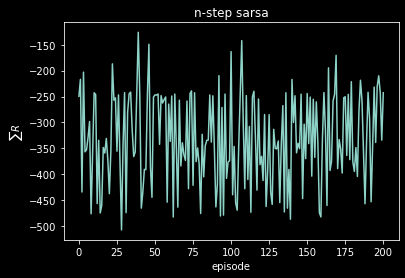

In [335]:
plot_rewards(cum_rew_n_step_sarsa, method='n-step sarsa')

In [336]:
tester(policy_n_step_sarsa)

## 5. *Task-3:* REINFORCE
- **UG:** 10 marks
- **PG:** 10 marks

Here you will need to implement the method REINFORCE that receives as an input
1. `env`, 
2. `num_episodes`, 
3. `alpha`, 
4. `gamma`, 


And returns
1. `policy_grad`
2. `cumulative_rewards`

 Check also the pseudo-code in the textbook [http://www.incompleteideas.net/book/RLbook2020.pdf ](Reinforcement Learning: an Introduction) Page 328. You DO NOT have to test it (since we have not seen how to implement the approximations for this method)

In [337]:
def feature(s,a,d):
    return np.ones(d)


This is a function that you can use for your approximation, for any entry $(s,a,d)$ with $d$=dimension of the weights, it returns a vector (with $d$ components) of ones. 

**Task** Implement the function softmax defined by equation (13.2) in [http://www.incompleteideas.net/book/RLbook2020.pdf ]

In [338]:
def soft_max(S,A,theta): # S and A should be vectors
    e_x = np.exp(np.dot(S,A,theta) - np.max(np.dot(S,A,theta)))
    return e_x / e_x.sum(axis=0)

In [339]:
def reinforce(env, num_episodes, alpha, gamma):
    theta = np.zeros([d_theta, d_theta, d_omega, d_T])
    policy = np.zeros((d_theta, d_theta, d_omega), dtype=int)
    cumulative_reward_history = [] # we can use this to figure out how well the learning worked

    for i_episode in tqdm(range(num_episodes)):
        
        state = env.reset()
        disc_state = tuple(discretise_state(state))
        disc_action = np.random.choice(np.arange(d_T))
        for _ in range(num_steps):
            cont_action = continualise_action(disc_action)
            next_state, reward, done, info = env.step(cont_action)
            next_disc_state = tuple(discretise_state(next_state))
            
            # Computing gradient
            
            # Updating theta
            
            
    return policy, cumulative_rewards

## 6. (PGT Only) *Task-4*: SARSA($\lambda$)
- **PG:** 15 marks (10 for the implementation of the method, 5 if you test it in the enviroment)

**Task** implement the pseudo code in page 305 in [http://www.incompleteideas.net/book/RLbook2020.pdf ]
**Task** if you are able to define (explicitely) the feature vector, then you should test the policy using `plot_rewards()` and `tester()`

In [340]:
def sarsa_lambda(env, num_episodes, discount=0.9, alpha=0.01, decay=1, epsilon=0.1, type='accumulate'):
    
    Q = np.zeros([d_theta, d_theta, d_omega, d_T])
    E = np.zeros([d_theta, d_theta, d_omega, d_T])
    
    policy = np.zeros((d_theta, d_theta, d_omega), dtype=int)
    cumulative_reward_history = []
    epsilon *= decay
    alpha *= decay
    
    rewards = [0.]
    
    for _ in tqdm(range(num_episodes)):
    
        state = env.reset()
        disc_state = tuple(discretise_state(state))
        disc_action = np.random.choice(np.arange(d_T))

    
        for _ in range(num_steps):
    
            cont_action = continualise_action(disc_action)
            next_state, reward, done, info = env.step(cont_action)
            next_disc_state = tuple(discretise_state(next_state))
            rewards.append(reward)
    
            if np.random.uniform(0,1)<epsilon:
                next_disc_action = np.random.choice(range(d_T))
            else:
                next_disc_action = policy[next_disc_state]
            
            policy[disc_state] = np.argmax(Q[disc_state])
    
            delta = reward + discount*Q[next_disc_state][next_disc_action] - Q[disc_state][disc_action]
    
    
            E[disc_state][disc_action] += 1
    
            for s in range(len(Q)):
                Q[s][:] += alpha * delta * E[s][:]
                if type == 'accumulate':
                    E[s][:] *= decay * discount
                elif type == 'replace':
                    if s == state:
                        E[s][:] = 1
                    else:
                        E[s][:] *= discount * decay
    
            if done:
                break
    
            disc_state = next_disc_state
            disc_action = next_disc_action
            
            cumulative_reward_history.append(np.sum(rewards))
        
        return Q, policy, cumulative_reward_history

In [341]:
env = gym.make('Pendulum-v1').env

alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.1 # epsilon greedy parameter

num_episodes = 200 # number of episodes
num_steps = 50 # length of episodes

In [342]:
Qsl,psl,crsl = sarsa_lambda(env, num_episodes, gamma, alpha, epsilon)
env.close()

  0%|          | 0/200 [00:00<?, ?it/s]

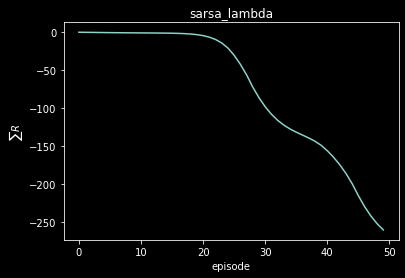

In [343]:
plot_rewards(crsl, method='sarsa_lambda')

In [344]:
tester(psl)